# Command: A new tool for building multi-agent architectures in LangGraph


Building agentic and multi-agent systems is all about communication.

Now, nodes can dynamically decide which node to execute next, improving flexibility and simplifying complex workflows.

#### **What's New:**
- **Edgeless graphs:** Nodes no longer need edges to connect. Instead, they can directly specify which node to go to next, making your agent flows more intuitive and adaptable.

- **Enhanced control:** Control the flow after the state update by returning a Command that points to the next node, enabling dynamic, real-time decision-making.

- **Edgeless graphs:** Nodes no longer need edges to connect. Instead, they can directly specify which node to go to next, making your agent flows more intuitive and adaptable.


In [2]:
%%capture --no-stderr
%pip install -U langgraph wikipedia langchain-community langchain-google-genai

Let's learn it with a simple example - An
AI-powered home search engine like: https://flyhomes.com/.


## S1: Understand Command Basic Usage

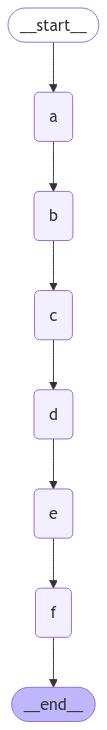

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
class State(TypedDict):
  value:str

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding this value {state['value']}")
    return {"value": self.value}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))
builder.add_node('e',ReturnedNodeValue("E"))
builder.add_node('f',ReturnedNodeValue("F"))

builder.add_edge(START,'a')
builder.add_edge('a','b')
builder.add_edge('b','c')
builder.add_edge('c','d')
builder.add_edge('d','e')
builder.add_edge('e','f')
builder.add_edge('f',END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [4]:
 resp = graph.invoke({"value":""})

Adding this value 
Adding this value A
Adding this value B
Adding this value C
Adding this value D
Adding this value E


Now, let's run `b` and `c` in parallel.

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

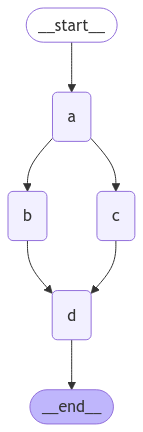

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
class State(TypedDict):
  value:str

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding this value {state['value']}")
    return {"value": self.value}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))

builder.add_edge(START,'a')
builder.add_edge('c','d')
builder.add_edge('b','d')
builder.add_edge('a','c')
builder.add_edge('a','b')
builder.add_edge('d',END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"value":""})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding this value 
Adding this value A
Adding this value A
An error occurred: At key 'value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

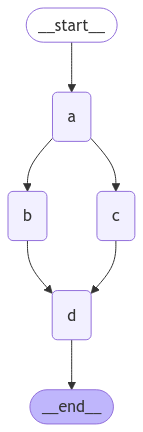

In [7]:
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
class State(TypedDict):
  value:Annotated[list,operator.add]

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding this value {state['value']}")
    return {"value": [self.value]}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))

builder.add_edge(START,'a')
builder.add_edge('c','d')
builder.add_edge('b','d')
builder.add_edge('a','c')
builder.add_edge('a','b')
builder.add_edge('d',END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"value":[]})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding this value []
Adding this value ['A']
Adding this value ['A']
Adding this value ['A', 'B', 'C']


## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

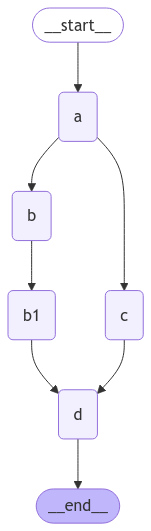

In [9]:
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
class State(TypedDict):
  value:Annotated[list,operator.add]

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding {self.value} to {state['value']}")
    return {"value": [self.value]}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('b1',ReturnedNodeValue('B1'))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))

builder.add_edge(START,'a')
builder.add_edge('a','b')
builder.add_edge('a','c')
builder.add_edge('b','b1')
builder.add_edge(['b1','c'],'d')



builder.add_edge('d',END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from langgraph.errors import InvalidUpdateError
try:
    resp=graph.invoke({"value":[]})
    print(resp)
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding A to []
Adding B to ['A']
Adding C to ['A']
Adding B1 to ['A', 'B', 'C']
Adding D to ['A', 'B', 'C', 'B1']
{'value': ['A', 'B', 'C', 'B1', 'D']}


## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**.

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

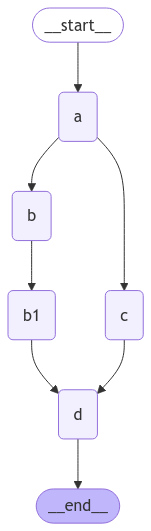

In [13]:
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
def sorting_reducer(left,right):
  if not isinstance(left,list):
    left = [left]
  if not isinstance(right,list):
    right = [right]
  return sorted(left + right, reverse=False)

class State(TypedDict):
  value:Annotated[list,sorting_reducer]

class ReturnedNodeValue:
  def __init__(self,value):
    self.value = value
  def __call__(self,state:State):
    print(f"Adding {self.value} to {state['value']}")
    return {"value": [self.value]}


builder = StateGraph(State)
builder.add_node('a',ReturnedNodeValue("A"))
builder.add_node('b',ReturnedNodeValue("B"))
builder.add_node('b1',ReturnedNodeValue('B1'))
builder.add_node('c',ReturnedNodeValue("C"))
builder.add_node('d',ReturnedNodeValue("D"))

builder.add_edge(START,'a')
builder.add_edge('a','b')
builder.add_edge('a','c')
builder.add_edge('b','b1')
builder.add_edge(['b1','c'],'d')



builder.add_edge('d',END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langgraph.errors import InvalidUpdateError
try:
    resp=graph.invoke({"value":[]})
    print(resp)
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding A to []
Adding B to ['A']
Adding C to ['A']
Adding B1 to ['A', 'B', 'C']
Adding D to ['A', 'B', 'B1', 'C']
{'value': ['A', 'B', 'B1', 'C', 'D']}


## Working with LLMs

Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')  # Get the API key from userdata
%env GOOGLE_API_KEY = {GOOGLE_API_KEY} # Set as env variable if needed.
if not GOOGLE_API_KEY:
    raise ValueError('GEMINI_API_KEY is not set in Colab secrets.')
print('GOOGLE_GEMINI_API_KEY is loaded successfully.')

In [35]:
from google.colab import userdata
from IPython import get_ipython

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

if GOOGLE_API_KEY and TAVILY_API_KEY:
    get_ipython().run_cell_magic('capture', '', '%env GOOGLE_API_KEY = {GOOGLE_API_KEY}')
    get_ipython().run_cell_magic('capture', '', '%env TAVILY_API_KEY = {TAVILY_API_KEY}')
    print('GOOGLE_GEMINI_API_KEY and TAVILY_API_KEY is loaded successfully.')
else:
    raise ValueError('GEMINI_API_KEY or TAVILY_API_KEY is not set in Colab secrets.')

GOOGLE_GEMINI_API_KEY and TAVILY_API_KEY is loaded successfully.


In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")


In [33]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-686d3438-bd81-42bd-8974-4a7dadfe3c61-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

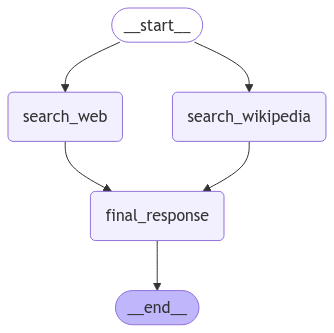

In [61]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
import operator
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image,display
class State(TypedDict):
  current_context:Annotated[list,operator.add]
  question:str
  answer:str

def search_web(state:State):
     """Retrieve docs from web search"""
     tavily_search = TavilySearchResults(max_results=3)

     tavily_resp = tavily_search.invoke(state["question"])
     formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in tavily_resp
        ]
     )

     return {"current_context": [formatted_search_docs]}
def search_wikipedia(state:State):
     """ Retrieve docs from wikipedia """
     search_docs = WikipediaLoader(query=state['question'],load_max_docs=2).load()
     formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

     return {"current_context": [formatted_search_docs]}
def final_response(state:State):
    """ Node to answer a question """
    current_context = state["current_context"]
    question = state["question"]
    answer_template = """Answer the question {question} using this context: {current_context}"""
    answer_instructions = answer_template.format(question=question,current_context=current_context)
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
    return {"answer": answer}

workflow = StateGraph(State)
workflow.add_node("search_web",search_web)
workflow.add_node("search_wikipedia",search_wikipedia)
workflow.add_node("final_response",final_response)


workflow.add_edge(START,"search_web")
workflow.add_edge(START,"search_wikipedia")
workflow.add_edge("search_web","final_response")
workflow.add_edge("search_wikipedia","final_response")
workflow.add_edge("final_response",END)
graph = workflow.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
resp = graph.invoke({"question":"Current prime minister of pakistan and give me complete "})
print(resp['answer'].content)

Based on the provided text, the current Prime Minister of Pakistan is **Shehbaz Sharif**.


In [64]:
resp['answer'].content

"The provided text does not state that Pakistan is at the top of Agentic AI.  While one document mentions Pakistan's awakening in the field of AI generally, and another discusses Agentic AI, there's no information connecting the two to suggest Pakistan's leading role in Agentic AI development."